In [177]:
# 회귀모형 
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 

# 쓸데없는 알림 방지
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import itertools

#통계적 모형
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#머신러닝
from sklearn import datasets
from sklearn import metrics

from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error #연속형일때 사용하는 경우 
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix #범주형(분류모델)

In [6]:
titanic_raw_data = pd.read_csv('C:/Users/scien/Videos/titanic/titanic_full_data.csv')

In [165]:
titanic_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1285 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1285 non-null   int64  
 1   Pclass    1285 non-null   int64  
 2   Name      1285 non-null   object 
 3   Sex       1285 non-null   object 
 4   Age       1030 non-null   float64
 5   SibSp     1285 non-null   int64  
 6   Parch     1285 non-null   int64  
 7   Ticket    1285 non-null   object 
 8   Fare      1284 non-null   float64
 9   Cabin     294 non-null    object 
 10  Embarked  1283 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 120.5+ KB


### 결측치, 문자열 데이터를 어떻게 전처리 해야하는가? 

- PassengerId (index)
- Name (지워버림)
- sex (원핫 인코딩으로 수치화)
- Ticket (지움)
- Cabin (빼줘)
- Embark (원핫 인코딩으로 수치화)

In [16]:
# PassengerId index화 
titanic_raw_data.set_index(['PassengerId'], inplace = True)

In [13]:
# 반응변수 Y를 만들자 
titanic_target = titanic_raw_data[['Survived']]

In [18]:
# Y 해당하는 survived 제외, 문자열 타입 Name, Cabin 제외 
columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare', 'Embarked']

In [22]:
# 입력변수 X를 만들자 
titanic_features = titanic_raw_data[columns]
titanic_features

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
1305,3,male,NaN,0,0,8.0500,S
1306,1,female,39.0,0,0,108.9000,C
1307,3,male,38.5,0,0,7.2500,S


In [29]:
# 문자열 자료를 이산형으로 만들기 
# 굳이 2개 다 쓸 필요가 없어 하나만 이용할 것임 drop_first = True
# 만일 female을 남기고 싶다면?
# columns=['male', 'female']

titanic_features[['feamle', 'male']] = pd.get_dummies(titanic_features['Sex'])

In [30]:
titanic_features.drop(columns=['Sex'], inplace=True)

In [31]:
titanic_features

,Pclass,Age,SibSp,Parch,Fare,Embarked,feamle,male
PassengerId,,,,,,,,
1,3,22.0,1,0,7.2500,S,0,1
2,1,38.0,1,0,71.2833,C,1,0
3,3,26.0,0,0,7.9250,S,1,0
4,1,35.0,1,0,53.1000,S,1,0
5,3,35.0,0,0,8.0500,S,0,1
...,...,...,...,...,...,...,...,...
1305,3,NaN,0,0,8.0500,S,0,1
1306,1,39.0,0,0,108.9000,C,1,0
1307,3,38.5,0,0,7.2500,S,0,1


In [33]:
titanic_features['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [39]:
dummy_columns = pd.get_dummies(titanic_feature['Embarked'], prefix='Embarked').columns

In [40]:
titanic_features[dummy_columns] = pd.get_dummies(titanic_feature['Embarked'], prefix='Embarked')

In [ ]:
titanic_features.drop(columns=['Embarked'], inplace=True)

In [66]:
# pd.cut(data, bins, label) n개의 구간별로 나누기 pd.cut

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80] # 시작과 끝값을 지정
labels = ['child', 'teens', '20s', '30s', '40s', '50s', '60s', '70s']

pd.cut(titanic_features['Age'], bins=bins, labels=labels).value_counts()

# 결측치 삭제 필요 

20s      612
30s      209
teens    156
40s      128
child     85
50s       62
60s       27
70s        6
Name: Age, dtype: int64

In [67]:
# 나이의 결측치 
titanic_features.Age.isna().sum()

0

In [68]:
# 평균 30살 
round(titanic_features.Age.mean())

30

In [69]:
# 나이 결측치를 평균 나이로 채워주기 
titanic_features.Age.fillna(round(titanic_features.Age.mean()), inplace=True)

In [70]:
titanic_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1285 entries, 1 to 1309
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1285 non-null   int64  
 1   Sex       1285 non-null   object 
 2   Age       1030 non-null   float64
 3   SibSp     1285 non-null   int64  
 4   Parch     1285 non-null   int64  
 5   Fare      1284 non-null   float64
 6   Embarked  1283 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 80.3+ KB


In [71]:
# Fare의 결측치 

titanic_features.loc[titanic_features.Fare.isna()]

,Pclass,Age,SibSp,Parch,Fare,feamle,male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1044,3,60.5,0,0,NaN,0,1,0,0,1


In [74]:
# 3등실의 평균 Fare는?
titanic_features.loc[titanic_features.Pclass == 3]['Fare'].mean()

13.269605772005766

In [78]:
titanic_features.Fare.fillna(round(titanic_features.loc[titanic_features.Pclass == 3]['Fare'].mean(), 4), inplace=True)

In [111]:
# 모든 결측치를 채웠다 
titanic_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1285 entries, 1 to 1309
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      1285 non-null   int64  
 1   SibSp       1285 non-null   int64  
 2   Parch       1285 non-null   int64  
 3   Fare        1285 non-null   float64
 4   feamle      1285 non-null   uint8  
 5   male        1285 non-null   uint8  
 6   Embarked_C  1285 non-null   uint8  
 7   Embarked_Q  1285 non-null   uint8  
 8   Embarked_S  1285 non-null   uint8  
 9   child       1285 non-null   uint8  
 10  teens       1285 non-null   uint8  
 11  20s         1285 non-null   uint8  
 12  30s         1285 non-null   uint8  
 13  40s         1285 non-null   uint8  
 14  50s         1285 non-null   uint8  
 15  60s         1285 non-null   uint8  
 16  70s         1285 non-null   uint8  
dtypes: float64(1), int64(3), uint8(13)
memory usage: 66.5 KB


In [83]:
# pd.cut(data, bins, label) n개의 구간별로 나누기 pd.cut

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80] # 시작과 끝값을 지정
labels = ['child', 'teens', '20s', '30s', '40s', '50s', '60s', '70s']

# 나이대를 컬럼화 
titanic_features['Ages'] = pd.cut(titanic_features['Age'], bins=bins, labels=labels)

In [87]:
# 컬럼화된 나이대를 변수 
age_columns = pd.get_dummies(titanic_features['Ages']).columns

In [88]:
# 이를 이용해 나이대를 수치화 시켜주고  
titanic_features[age_columns] = pd.get_dummies(titanic_features['Ages'])

In [89]:
# Age 데이터 마다 할당된 나이와 Ages 나이대를 삭제한다 
titanic_features.drop(columns=['Age', 'Ages'], inplace=True)

In [104]:
titanic_features

,Pclass,SibSp,Parch,Fare,feamle,male,Embarked_C,Embarked_Q,Embarked_S,child,teens,20s,30s,40s,50s,60s,70s
PassengerId,,,,,,,,,,,,,,,,,
1,3,1,0,7.2500,0,1,0,0,1,0,0,1,0,0,0,0,0
2,1,1,0,71.2833,1,0,1,0,0,0,0,0,1,0,0,0,0
3,3,0,0,7.9250,1,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,0,53.1000,1,0,0,0,1,0,0,0,1,0,0,0,0
5,3,0,0,8.0500,0,1,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,0,0,8.0500,0,1,0,0,1,0,0,1,0,0,0,0,0
1306,1,0,0,108.9000,1,0,1,0,0,0,0,0,1,0,0,0,0
1307,3,0,0,7.2500,0,1,0,0,1,0,0,0,1,0,0,0,0


In [121]:
print(titanic_features.isna().sum())
print(titanic_target.isna().sum())

Pclass        0
SibSp         0
Parch         0
Fare          0
feamle        0
male          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
child         0
teens         0
20s           0
30s           0
40s           0
50s           0
60s           0
70s           0
dtype: int64
Survived    0
dtype: int64


In [106]:
train_x, test_x, train_y, test_y = train_test_split(titanic_features, titanic_target, train_size=0.8, random_state = 123)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1028, 17) (257, 17) (1028, 1) (257, 1)


In [136]:
# 통계 모델에서 제공 
#model = sm.Logit(train_y, train_x).fit()
#print(titanic_features.isna().sum())
#print(titanic_target.isna().sum())

In [131]:
# 머신러닝 제공 
model = LogisticRegression().fit(train_x, train_y)

In [115]:
model.coef_

array([[-0.80595348, -0.31586458, -0.10386631,  0.0026601 ,  1.52243969,
        -0.92866883,  0.44490853,  0.15749217, -0.00862984,  1.50261608,
         0.17862047,  0.18323464,  0.15796847, -0.11252973, -0.14279755,
        -1.03544688, -0.13789463]])

In [133]:
pd.DataFrame(train_x.columns)

,0
0,Pclass
1,SibSp
2,Parch
3,Fare
4,feamle
5,male
6,Embarked_C
7,Embarked_Q
8,Embarked_S
9,child


In [134]:
train_x.columns

Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'feamle', 'male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'child', 'teens', '20s', '30s', '40s',
       '50s', '60s', '70s'],
      dtype='object')

In [135]:
pd.concat([pd.DataFrame(model.coef_.T), pd.DataFrame(train_x.columns)], axis=1)

,0,0
0,-0.805953,Pclass
1,-0.315865,SibSp
2,-0.103866,Parch
3,0.002660,Fare
4,1.522440,feamle
5,-0.928669,male
6,0.444909,Embarked_C
7,0.157492,Embarked_Q
8,-0.008630,Embarked_S
9,1.502616,child


In [137]:
pred_y = model.predict(test_x)

In [146]:
pd.DataFrame(pred_y)

,0
0,1
1,0
2,0
3,0
4,1
...,...
252,1
253,0
254,0
255,0


In [147]:
pd.DataFrame(test_y)

,Survived
43,1
824,0
221,0
975,1
780,1
...,...
585,1
304,0
120,0
250,0


두 데이터의 인덱스가 맞지않는다. 

In [162]:
test_y['Survived']

43     1
824    0
221    0
975    1
780    1
      ..
585    1
304    0
120    0
250    0
228    0
Name: Survived, Length: 257, dtype: int64

In [168]:
pd.concat([pd.DataFrame(test_y.values, columns=['Y']), pd.DataFrame(pred_y,  columns=['Yhat'])], axis=1)

,Y,Yhat
0,1,1
1,0,0
2,0,0
3,1,0
4,1,1
...,...,...
252,1,1
253,0,0
254,0,0
255,0,0


In [178]:
cmat = confusion_matrix(test_y, pred_y)
cmat

array([[134,  17],
       [ 36,  70]], dtype=int64)

## 컨퓨전 메트릭스 짚어보고가기
-

In [179]:
# 생존을 생존으로 예측, 사망을 사망으로 예측한, Accuracy
(cmat[0,0]+ cmat[1,1])/np.sum(cmat)

0.7937743190661478

In [188]:
test_y['Survived'].value_counts()

0    151
1    106
Name: Survived, dtype: int64

findfont: Font family ['NanumGothicCoding'] not found. Falling back to DejaVu Sans.


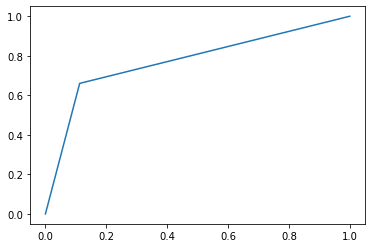

In [189]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y, pos_label=1)
plt.plot(fpr, tpr)
plt.show()